music_recommendation

#**Project Name** - Spotify Recommendation

  A music recommendation project that uses clustering to categorize music genres based on
audio characteristics. We're using a Kaggle dataset that includes popular Spotify songs as well
as audio feature information for each one.

##**Installation of Preferred Installer Program (PIP)**

In [152]:
!pip install pydotplus
!pip install six
!pip install python-magic

##**Importing Libraries**

In [153]:
#general tools
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image, HTML
import pydot
from plotnine import *
from tqdm import tqdm

In [154]:
#for transformation and prediction
from scipy.optimize import curve_fit
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, DBSCAN
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
from six import StringIO


In [155]:
#for scoring
from sklearn.metrics import mean_squared_error as mse

In [156]:
# For validation
from sklearn.model_selection import train_test_split as split

#**Data Insight**

###**First Glance of Dataset**

In [157]:
#To read dataset from Drive Withouting Mounting

#csv_file_url = 'https://drive.google.com/file/d/10hbMqtjQrESeA_JHBuKA2kVvD6hR-wMZ/view?usp=sharing'
#file_id = csv_file_url.split('/')[-2]
#dwn_url = 'https://drive.google.com/uc?export=download&id=' + file_id
df = pd.read_csv("/content/Spotify-2000.csv")
df.head()

index                   title             artist             topGener  \
0      1                 Sunrise        Norah Jones      adult standards   
1      2             Black Night        Deep Purple           album rock   
2      3          Clint Eastwood           Gorillaz  alternative hip hop   
3      4           The Pretender       Foo Fighters    alternative metal   
4      5  Waitin' On A Sunny Day  Bruce Springsteen         classic rock   

   year  beatsPerMinute  energy  danceability  loudness  liveness  valence  \
0  2004             157      30            53       -14        11       68   
1  2000             135      79            50       -11        17       81   
2  2001             168      69            66        -9         7       52   
3  2007             173      96            43        -4         3       37   
4  2002             106      82            58        -5        10       87   

  length  acousticness  speechiness  popularity  
0    201            94            3          71  
1    207            17            7          39  
2    341             2           17          69  
3    269             0            4          76  
4    256             1            3          59

###**Data Information**

In [158]:
#Show the summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           1994 non-null   int64 
 1   title           1994 non-null   object
 2   artist          1994 non-null   object
 3   topGener        1994 non-null   object
 4   year            1994 non-null   int64 
 5   beatsPerMinute  1994 non-null   int64 
 6   energy          1994 non-null   int64 
 7   danceability    1994 non-null   int64 
 8   loudness        1994 non-null   int64 
 9   liveness        1994 non-null   int64 
 10  valence         1994 non-null   int64 
 11  length          1994 non-null   object
 12  acousticness    1994 non-null   int64 
 13  speechiness     1994 non-null   int64 
 14  popularity      1994 non-null   int64 
dtypes: int64(11), object(4)
memory usage: 233.8+ KB


In [159]:
df['length']=df['length'].apply(lambda x: int(x.replace(',','')))

##Variables Description

index - identifier for music

title - identifier for song title

artist - identifier for artist

year - identifier for year

In [160]:
#Unique Values in dataset
columns = ['index', 'title', 'artist', 'year']
for col in columns:
  print(f'{col:<15}: {df[col].nunique()} unique values')

index          : 1994 unique values
title          : 1958 unique values
artist         : 731 unique values
year           : 63 unique values


##Dropping Variable

In [161]:
#parallel data set to reatin title
og_titled_dataset = df.drop(labels=['index',], axis=1)
og_titled_dataset.shape
og_titled_dataset.head(10)

title             artist  \
0                                Sunrise        Norah Jones   
1                            Black Night        Deep Purple   
2                         Clint Eastwood           Gorillaz   
3                          The Pretender       Foo Fighters   
4                 Waitin' On A Sunny Day  Bruce Springsteen   
5  The Road Ahead (Miles Of The Unknown)       City To City   
6                      She Will Be Loved           Maroon 5   
7                     Knights of Cydonia               Muse   
8                         Mr. Brightside        The Killers   
9                             Without Me             Eminem   

               topGener  year  beatsPerMinute  energy  danceability  loudness  \
0       adult standards  2004             157      30            53       -14   
1            album rock  2000             135      79            50       -11   
2   alternative hip hop  2001             168      69            66        -9   
3     alternative metal  2007             173      96            43        -4   
4          classic rock  2002             106      82            58        -5   
5  alternative pop rock  2004              99      46            54        -9   
6                   pop  2002             102      71            71        -6   
7           modern rock  2006             137      96            37        -5   
8           modern rock  2004             148      92            36        -4   
9       detroit hip hop  2002             112      67            91        -3   

   liveness  valence  length  acousticness  speechiness  popularity  
0        11       68     201            94            3          71  
1        17       81     207            17            7          39  
2         7       52     341             2           17          69  
3         3       37     269             0            4          76  
4        10       87     256             1            3          59  
5        14       14     247             0            2          45  
6        13       54     257             6            3          74  
7        12       21     366             0           14          69  
8        10       23     223             0            8          77  
9        24       66     290             0            7          82

In [162]:
# To drop Value not needed in the dataset.
# Example index and title is not needed in this dataset for recommedation
df = df.drop(labels=['index', 'title',], axis=1)
df.shape

(1994, 13)

##Duplicate Values

In [163]:
#To identify and count the number of duplicate.
df.duplicated().sum()

0

In [164]:
#Indicating the number of rows and columns remaining.
df = df[~df.duplicated()==1]
df.shape

(1994, 13)

##Missing Values / Null Values

In [165]:
#Viszualize the presence of missing values
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")

<Axes: >

##Summary Statistics

In [166]:
#To generate descriptive statistics that summarize the central tendency, dispersion, and count.
df.describe()

year  beatsPerMinute       energy  danceability     loudness  \
count  1994.000000     1994.000000  1994.000000   1994.000000  1994.000000   
mean   1992.992979      120.215647    59.679539     53.238215    -9.008526   
std      16.116048       28.028096    22.154322     15.351507     3.647876   
min    1956.000000       37.000000     3.000000     10.000000   -27.000000   
25%    1979.000000       99.000000    42.000000     43.000000   -11.000000   
50%    1993.000000      119.000000    61.000000     53.000000    -8.000000   
75%    2007.000000      136.000000    78.000000     64.000000    -6.000000   
max    2019.000000      206.000000   100.000000     96.000000    -2.000000   

          liveness      valence       length  acousticness  speechiness  \
count  1994.000000  1994.000000  1994.000000   1994.000000  1994.000000   
mean     19.012036    49.408726   262.443330     28.858074     4.994985   
std      16.727378    24.858212    93.604387     29.011986     4.401566   
min       2.000000     3.000000    93.000000      0.000000     2.000000   
25%       9.000000    29.000000   212.000000      3.000000     3.000000   
50%      12.000000    47.000000   245.000000     18.000000     4.000000   
75%      23.000000    69.750000   289.000000     50.000000     5.000000   
max      99.000000    99.000000  1412.000000     99.000000    55.000000   

       popularity  
count  1994.00000  
mean     59.52658  
std      14.35160  
min      11.00000  
25%      49.25000  
50%      62.00000  
75%      71.00000  
max     100.00000

# Part 1: Exploratory Data Analysis (EDA) Overview

In [167]:
#To check the column for how many are numeric columns and how many are string column
numeric_columns = df.columns[df.dtypes != 'object']
string_columns = df.columns[df.dtypes == 'object']
print(f'There are {len(numeric_columns)} numeric columns & {len(string_columns)} string columns')

There are 11 numeric columns & 2 string columns


##Display the Data Types

In [168]:
#to display the data types of each column
df.dtypes

artist            object
topGener          object
year               int64
beatsPerMinute     int64
energy             int64
danceability       int64
loudness           int64
liveness           int64
valence            int64
length             int64
acousticness       int64
speechiness        int64
popularity         int64
dtype: object

In [169]:
#To display the names of all columns
df.columns

Index(['artist', 'topGener', 'year', 'beatsPerMinute', 'energy',
       'danceability', 'loudness', 'liveness', 'valence', 'length',
       'acousticness', 'speechiness', 'popularity'],
      dtype='object')

##Calculate the Skew

In [170]:
#to calculate the skewness for each numeric column
df.loc[:,['year', 'beatsPerMinute', 'energy', 'danceability',
       'loudness', 'liveness', 'valence', 'acousticness',
       'speechiness', 'popularity']].skew()

year             -0.120997
beatsPerMinute    0.418443
energy           -0.248118
danceability      0.015472
loudness         -0.824486
liveness          2.376501
valence           0.201926
acousticness      0.797089
speechiness       4.899413
popularity       -0.533533
dtype: float64

# **Data Visualization**

Histogram of each music attributes.

In [171]:
# Creating subplots with multiple histograms
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
ncolumns =["acousticness","speechiness","danceability","loudness","length","popularity","valence","liveness","energy","beatsPerMinute","popular_artist"]

k=0
for i in range(5):
  for j in range(2):
      axes[i][j].hist(df[ncolumns[k]], bins=30, color='orange', edgecolor='black')
      axes[i][j].set_title(f'Histogram {ncolumns[k]}')
      axes[i][j].set_xlabel('Values')
      axes[i][j].set_ylabel('Frequency')
      k+=1

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()


In [172]:
correlation_matrix = df.corr(numeric_only=True)

##Heatmap - Correlation

In [173]:
# Numeric Heatmap- This is to check the correlation between the numeric features in the dataset
numeric_df = pd.DataFrame(data=df, columns=numeric_columns, index=df.index)
corr = np.abs(numeric_df.corr())
fig, ax = plt.subplots(figsize=(10, 8))
cmap = sns.color_palette("magma")
sns.heatmap(corr, cmap=cmap, square=True, annot = True)
plt.title('Correlation between numerical features')
plt.show()

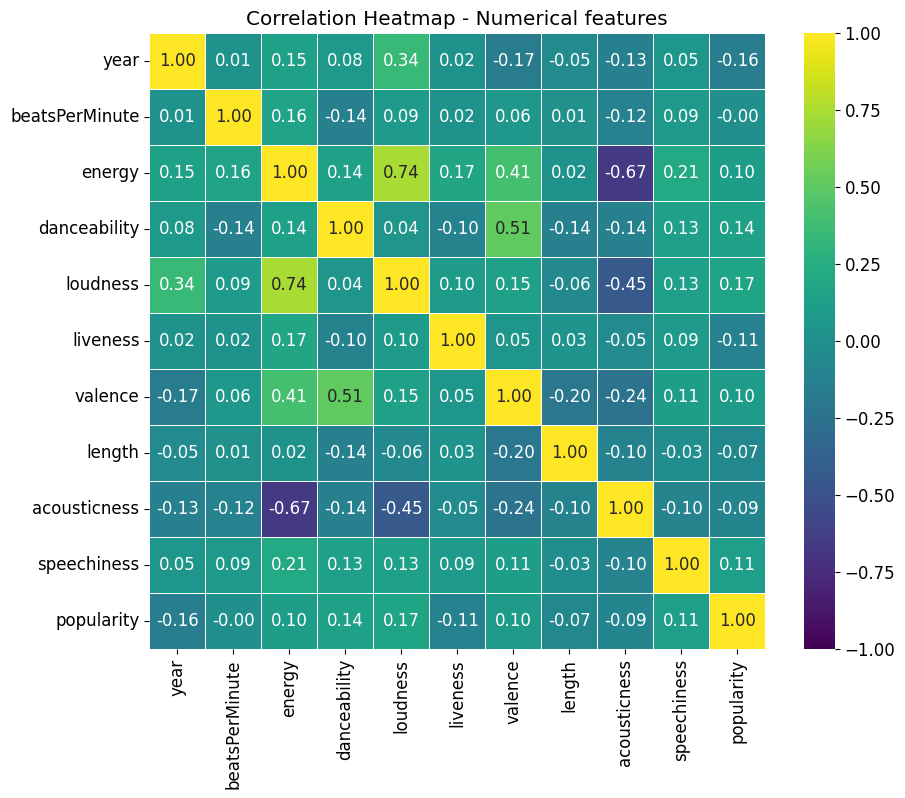

In [174]:
# Create an annotated heatmap
plt.figure(figsize = (10,8))
plt.rcParams.update({'font.size': 12})
sns.heatmap(correlation_matrix, cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5)
plt.title('Correlation Heatmap - Numerical features')
plt.show()

##Scatterplot

In [175]:
# Pairplot of Numerical Features to check the correction of each data point(features) to each other within the the dataset
# Data is sampled here due to long running time
#g = sns.pairplot(df, vars=["energy", "danceability", "loudnessdB", "liveness", "valence", "acousticness", "speechiness",  "popularity"], diag_kind="kde")
g = sns.pairplot(df, vars=numeric_columns, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")
plt.show()

##Bivariate Analysis

The relation of energy and loudness is that the higher energy in music typically results in higher loudness. This is because energetic music often features stronger beats, faster tempos, and more intense dynamics, all contributing to its perceived loudness.

In [176]:
#Compare two music attributes to understand the relation of both.
selected_columns = ['energy', 'loudness']
sns.pairplot(df[selected_columns])
plt.show()

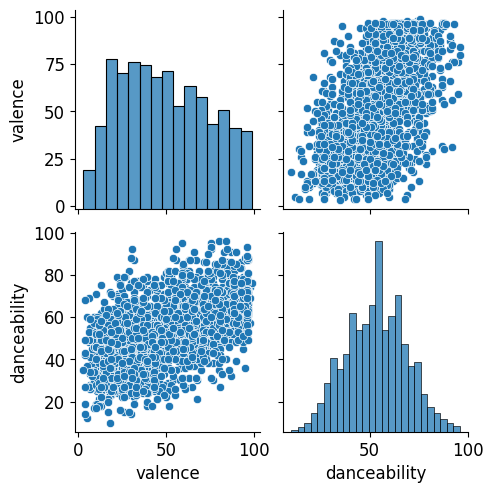

In [177]:
#Compare two music attributes to understand the relation of both.
selected_columns = ['valence', 'danceability']
sns.pairplot(df[selected_columns])
plt.show()

Part Two: EDA for Categorical data

In [178]:
#categories = ['popularity', 'artist', 'topGenre']
#explode = (0.1, 0, 0)
#labels = ['Popularity', 'Artist', 'Top Genre']
#plt.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
#       shadow=True, startangle=90)
#plt.title('Percentage of Categorical Data')
#lt.show()

In [179]:
# To the number of artist in the dataset because its a good categorical feature we can you to categories our dataset
df['artist'].nunique()

731

In [180]:
#  Plotting graph for the Top 20 artist
fig, ax = plt.subplots(figsize = (12, 10))
lead_artists = df.groupby('artist')['popularity'].sum().sort_values(ascending=False).head(20)
ax = sns.barplot(x=lead_artists.values, y=lead_artists.index, palette="Greens", orient="h", edgecolor='black', ax=ax)
ax.set_xlabel('Sum of Popularity', c='r', fontsize=12)
ax.set_ylabel('artist', c='r', fontsize=12)
ax.set_title('20 Most Popular Artists in Dataset', c='r', fontsize=14, weight = 'bold')
plt.show()

<ipython-input-180-ab79234cf9cf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



In [181]:
# find out artists with more than 10 tracks
df['popular_artist'] = df['artist'].map(df['artist'].value_counts()>10)
pop_arts  = df.groupby(['artist', 'popular_artist'])['popularity'].mean().sort_values(ascending=False).reset_index(1)
df_pop_arts = pop_arts.loc[pop_arts['popular_artist'] == True,['popularity']]

## Plotting the graph
fig, ax = plt.subplots(figsize = (12, 10))
lead_artists = df_pop_arts.groupby('artist')['popularity'].mean().sort_values(ascending=False).head(20)
ax = sns.barplot(x=lead_artists.values, y=lead_artists.index, palette="Greens", orient="h", edgecolor='black', ax=ax)
ax.set_xlabel('Mean of Popularity', c='r', fontsize=12)
ax.set_ylabel('Artist', c='r', fontsize=12)
ax.set_title('20 Most Popular Artists in Dataset with > 10 tracks', c='r', fontsize=14, weight = 'bold')
plt.show()


<ipython-input-181-bd4a696cb3ac>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



In [182]:
# plot histogram
#plt.hist(df["bpm"], bins=30, color='skyblue', edgecolor='black')

# Adding labels and title
#plt.xlabel('energy123')
#plt.ylabel('Frequency')
#plt.title('Basic Histogram')

# Display the plot
#plt.show()

##Boxplot

In [183]:
#box plot for extreme value
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
ncolumns =["acousticness","speechiness","danceability","loudness","length","popularity","valence","liveness","energy","beatsPerMinute"]

k=0
for i in range(5):
  for j in range(2):
      axes[i][j].boxplot(df[ncolumns[k]],1)
      axes[i][j].set_title(f'boxplot {ncolumns[k]}')
      axes[i][j].set_xlabel('Values')
      axes[i][j].set_ylabel('Frequency')
      k+=1

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()


We have used box plots to get a summary of the distribution, central tendency, and variability of
our numerical parameters. It allowed us to gauge the comparative range of each parameter, and
their outliers, and detect skewness. Here we can see speechiness and liveness have long
whiskers due to their skewed nature.

In [184]:
#Normalization
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
normalizedColunm = scaler.fit_transform(df[ncolumns])
scaledDf =pd.DataFrame(normalizedColunm, columns=ncolumns)
scaledDf.head(10)


acousticness  speechiness  danceability  loudness    length  popularity  \
0      2.245908    -0.453358     -0.015521 -1.368667 -0.656580    0.799653   
1     -0.408833     0.455637     -0.210991 -0.546064 -0.592464   -1.430623   
2     -0.925990     2.728126      0.831514  0.002338  0.839452    0.660261   
3     -0.994944    -0.226109     -0.667086  1.373342  0.070064    1.148133   
4     -0.960467    -0.453358      0.310261  1.099141 -0.068853   -0.036701   
5     -0.994944    -0.680607      0.049635  0.002338 -0.165026   -1.012446   
6     -0.788081    -0.453358      1.157296  0.824940 -0.058167    1.008741   
7     -0.994944     2.046379     -1.058026  1.099141  1.106600    0.660261   
8     -0.994944     0.682886     -1.123182  1.373342 -0.421489    1.217830   
9     -0.994944     0.455637      2.460427  1.647543  0.294469    1.566310   

    valence  liveness    energy  beatsPerMinute  
0  0.748080 -0.479098 -1.340009        1.312739  
1  1.271177 -0.120314  0.872304        0.527616  
2  0.104268 -0.718286  0.420812        1.705301  
3 -0.499305 -0.957475  1.639841        1.883738  
4  1.512607 -0.538895  1.007752       -0.507320  
5 -1.424785 -0.299706 -0.617621       -0.757132  
6  0.184745 -0.359503  0.511110       -0.650070  
7 -1.143117 -0.419300  1.639841        0.598991  
8 -1.062641 -0.538895  1.459244        0.991552  
9  0.667604  0.298266  0.330513       -0.293195

In [185]:
from sklearn.preprocessing import OneHotEncoder

#Encoding One-hot encoding
categorical_columns = ["artist", "topGener", "year"]
#categorical_columns = string_columns

encoder = OneHotEncoder(sparse_output=False,min_frequency=5, drop ='first',handle_unknown='ignore')
encoder.fit(df[categorical_columns])


OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=5,
              sparse_output=False)

In [186]:
encoded_array =  encoder.transform(df[categorical_columns])
one_hot_columns_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_columns), index=df.index)
data = pd.concat([df, one_hot_columns_df], axis=1)
data = data.drop(categorical_columns, axis=1)

In [187]:
data.head(10)

beatsPerMinute  energy  danceability  loudness  liveness  valence  length  \
0             157      30            53       -14        11       68     201   
1             135      79            50       -11        17       81     207   
2             168      69            66        -9         7       52     341   
3             173      96            43        -4         3       37     269   
4             106      82            58        -5        10       87     256   
5              99      46            54        -9        14       14     247   
6             102      71            71        -6        13       54     257   
7             137      96            37        -5        12       21     366   
8             148      92            36        -4        10       23     223   
9             112      67            91        -3        24       66     290   

   acousticness  speechiness  popularity  ...  year_2011  year_2012  \
0            94            3          71  ...        0.0        0.0   
1            17            7          39  ...        0.0        0.0   
2             2           17          69  ...        0.0        0.0   
3             0            4          76  ...        0.0        0.0   
4             1            3          59  ...        0.0        0.0   
5             0            2          45  ...        0.0        0.0   
6             6            3          74  ...        0.0        0.0   
7             0           14          69  ...        0.0        0.0   
8             0            8          77  ...        0.0        0.0   
9             0            7          82  ...        0.0        0.0   

   year_2013  year_2014  year_2015  year_2016  year_2017  year_2018  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        0.0        0.0        0.0        0.0   
6        0.0        0.0        0.0        0.0        0.0        0.0   
7        0.0        0.0        0.0        0.0        0.0        0.0   
8        0.0        0.0        0.0        0.0        0.0        0.0   
9        0.0        0.0        0.0        0.0        0.0        0.0   

   year_2019  year_infrequent_sklearn  
0        0.0                      0.0  
1        0.0                      0.0  
2        0.0                      0.0  
3        0.0                      0.0  
4        0.0                      0.0  
5        0.0                      0.0  
6        0.0                      0.0  
7        0.0                      0.0  
8        0.0                      0.0  
9        0.0                      0.0  

[10 rows x 233 columns]

###Model Building

In [188]:
def optimize_k_clustures(data, max_clusters=10):
  means=[]
  inertias = []
  for i in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=i,)
    kmeans.fit(data)
    means.append(kmeans.inertia_)
    inertias.append(kmeans.inertia_)
  return means, inertias

def generate_elbow_plot(means, inertias):
  fig = plt.subplots(figsize=(10, 5))
  plt.plot(range(1, len(means)+1), means, marker='o', linestyle='--')
  plt.plot(range(1, len(inertias)+1), inertias, marker='o', linestyle='--')
  plt.xlabel('Number of clusters')
  plt.ylabel('Inertia')
  plt.legend(['Means', 'Inertia'])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10

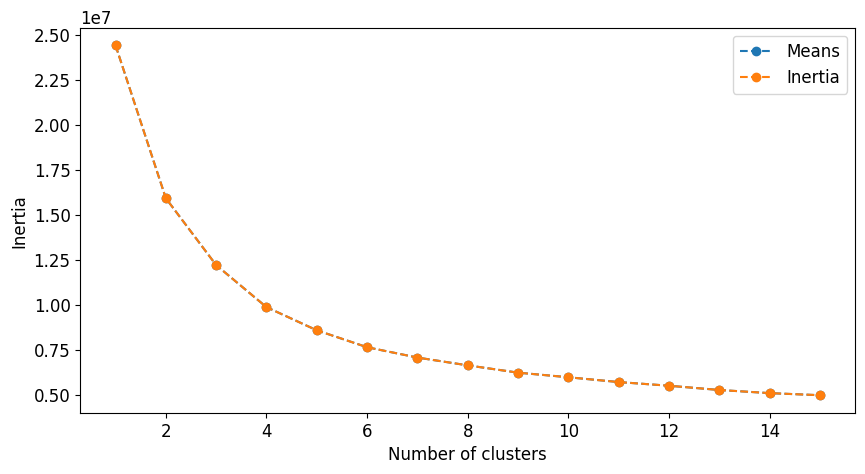

In [189]:
means, inertias = optimize_k_clustures(data, 15)
generate_elbow_plot(means, inertias)

In [190]:
n=10
kmeans = KMeans(n_clusters=n)
kmeans.fit(data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


KMeans(n_clusters=10)

In [191]:
clustures_array = kmeans.predict(data)
cluature_pf = pd.DataFrame(clustures_array, columns=['clusture'], index=data.index)
data = pd.concat([data, cluature_pf], axis=1)

In [192]:
data.head(10)

beatsPerMinute  energy  danceability  loudness  liveness  valence  length  \
0             157      30            53       -14        11       68     201   
1             135      79            50       -11        17       81     207   
2             168      69            66        -9         7       52     341   
3             173      96            43        -4         3       37     269   
4             106      82            58        -5        10       87     256   
5              99      46            54        -9        14       14     247   
6             102      71            71        -6        13       54     257   
7             137      96            37        -5        12       21     366   
8             148      92            36        -4        10       23     223   
9             112      67            91        -3        24       66     290   

   acousticness  speechiness  popularity  ...  year_2012  year_2013  \
0            94            3          71  ...        0.0        0.0   
1            17            7          39  ...        0.0        0.0   
2             2           17          69  ...        0.0        0.0   
3             0            4          76  ...        0.0        0.0   
4             1            3          59  ...        0.0        0.0   
5             0            2          45  ...        0.0        0.0   
6             6            3          74  ...        0.0        0.0   
7             0           14          69  ...        0.0        0.0   
8             0            8          77  ...        0.0        0.0   
9             0            7          82  ...        0.0        0.0   

   year_2014  year_2015  year_2016  year_2017  year_2018  year_2019  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        0.0        0.0        0.0        0.0   
6        0.0        0.0        0.0        0.0        0.0        0.0   
7        0.0        0.0        0.0        0.0        0.0        0.0   
8        0.0        0.0        0.0        0.0        0.0        0.0   
9        0.0        0.0        0.0        0.0        0.0        0.0   

   year_infrequent_sklearn  clusture  
0                      0.0         0  
1                      0.0         8  
2                      0.0         7  
3                      0.0         1  
4                      0.0         4  
5                      0.0         4  
6                      0.0         4  
7                      0.0         7  
8                      0.0         1  
9                      0.0         9  

[10 rows x 234 columns]

In [193]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Features for KNN (excluding 'popularity')
features_for_knn = data.drop('popularity', axis=1)

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_knn)

# Fit KNN model
knn_model = NearestNeighbors(n_neighbors=10)
knn_model.fit(scaled_features)

NearestNeighbors(n_neighbors=10)

In [194]:
# Function to find similar songs, default get only 5 songs if num_neighbors parameter was not passed any arguments
def get_similar_songs(song_index, num_neighbors = 5):
    distances, indices = knn_model.kneighbors(scaled_features[song_index].reshape(1, -1), n_neighbors=num_neighbors)
    similar_song_indices = indices[0][1:]  # Exclude the song itself
    similar_songs_df = data.iloc[similar_song_indices].copy()
    return similar_songs_df.head(num_neighbors)

In [195]:
# Define the common columns for the join
join_cols = ['beatsPerMinute', 'energy','danceability', 'loudness', 'liveness', 'valence', 'length', 'acousticness', 'speechiness', 'popularity']

# Example usage: Find similar songs for the song at index 100
songIndex = 500
numOfSimilarSongsNeeded = 10

titledSongsDF = pd.merge(data, og_titled_dataset[['artist', 'topGener', 'year', 'title'] + join_cols], on=join_cols, how='left')
#titledSongsDF = data.merge(og_titled_dataset[['artist', 'topGener', 'year', 'title'] + join_cols], on=join_cols, how='left')
titledSongsDF.head(10)

beatsPerMinute  energy  danceability  loudness  liveness  valence  length  \
0             157      30            53       -14        11       68     201   
1             135      79            50       -11        17       81     207   
2             168      69            66        -9         7       52     341   
3             173      96            43        -4         3       37     269   
4             106      82            58        -5        10       87     256   
5              99      46            54        -9        14       14     247   
6             102      71            71        -6        13       54     257   
7             137      96            37        -5        12       21     366   
8             148      92            36        -4        10       23     223   
9             112      67            91        -3        24       66     290   

   acousticness  speechiness  popularity  ...  year_2016  year_2017  \
0            94            3          71  ...        0.0        0.0   
1            17            7          39  ...        0.0        0.0   
2             2           17          69  ...        0.0        0.0   
3             0            4          76  ...        0.0        0.0   
4             1            3          59  ...        0.0        0.0   
5             0            2          45  ...        0.0        0.0   
6             6            3          74  ...        0.0        0.0   
7             0           14          69  ...        0.0        0.0   
8             0            8          77  ...        0.0        0.0   
9             0            7          82  ...        0.0        0.0   

   year_2018  year_2019  year_infrequent_sklearn  clusture             artist  \
0        0.0        0.0                      0.0         0        Norah Jones   
1        0.0        0.0                      0.0         8        Deep Purple   
2        0.0        0.0                      0.0         7           Gorillaz   
3        0.0        0.0                      0.0         1       Foo Fighters   
4        0.0        0.0                      0.0         4  Bruce Springsteen   
5        0.0        0.0                      0.0         4       City To City   
6        0.0        0.0                      0.0         4           Maroon 5   
7        0.0        0.0                      0.0         7               Muse   
8        0.0        0.0                      0.0         1        The Killers   
9        0.0        0.0                      0.0         9             Eminem   

               topGener  year                                  title  
0       adult standards  2004                                Sunrise  
1            album rock  2000                            Black Night  
2   alternative hip hop  2001                         Clint Eastwood  
3     alternative metal  2007                          The Pretender  
4          classic rock  2002                 Waitin' On A Sunny Day  
5  alternative pop rock  2004  The Road Ahead (Miles Of The Unknown)  
6                   pop  2002                      She Will Be Loved  
7           modern rock  2006                     Knights of Cydonia  
8           modern rock  2004                         Mr. Brightside  
9       detroit hip hop  2002                             Without Me  

[10 rows x 238 columns]

In [196]:
# Display selected test song
print("Test song selected : \n")
print(titledSongsDF.iloc[songIndex])

Test song selected : 

beatsPerMinute                131
energy                         24
danceability                   75
loudness                      -13
liveness                       44
                       ...       
clusture                        0
artist            Youp van 't Hek
topGener            dutch cabaret
year                         2012
title                     Flappie
Name: 500, Length: 238, dtype: object


In [197]:
# Display similar songs without title
print("\nSimilar songs: \n")
similar_songs_df = get_similar_songs(songIndex, numOfSimilarSongsNeeded+1)

"""Add 1 to include the identify and include 1 extra song
as the song at index 0 is the seleceted test song and we are excluding it; this will get you 10 new songs if you set numOfSimilarSongsNeeded = 10"""

similar_songs_df.head(numOfSimilarSongsNeeded)


Similar songs: 



beatsPerMinute  energy  danceability  loudness  liveness  valence  \
512              124      39            61       -11        11       22   
506              137      30            59       -10        12       14   
515              112      31            62       -10        12       13   
505               73      28            61        -9         9       39   
514              119      26            46        -8        11       23   
516               92      71            56        -5        11       39   
519              132      68            52        -5         6       11   
518              103      76            45        -5        15       42   
496              146      92            64        -4         9       85   
1987             119      24            75       -15         9       43   

      length  acousticness  speechiness  popularity  ...  year_2012  \
512      255            53            4          67  ...        1.0   
506      240            69            4          72  ...        1.0   
515      241            95            3          66  ...        1.0   
505      214            93            4          82  ...        1.0   
514      221            92            4          46  ...        1.0   
516      225             0            5          67  ...        1.0   
519      214             8            4          56  ...        1.0   
518      267             2            3          75  ...        1.0   
496      258             3            8          83  ...        1.0   
1987     216            83           12          68  ...        0.0   

      year_2013  year_2014  year_2015  year_2016  year_2017  year_2018  \
512         0.0        0.0        0.0        0.0        0.0        0.0   
506         0.0        0.0        0.0        0.0        0.0        0.0   
515         0.0        0.0        0.0        0.0        0.0        0.0   
505         0.0        0.0        0.0        0.0        0.0        0.0   
514         0.0        0.0        0.0        0.0        0.0        0.0   
516         0.0        0.0        0.0        0.0        0.0        0.0   
519         0.0        0.0        0.0        0.0        0.0        0.0   
518         0.0        0.0        0.0        0.0        0.0        0.0   
496         0.0        0.0        0.0        0.0        0.0        0.0   
1987        0.0        0.0        0.0        0.0        0.0        0.0   

      year_2019  year_infrequent_sklearn  clusture  
512         0.0                      0.0         6  
506         0.0                      0.0         6  
515         0.0                      0.0         6  
505         0.0                      0.0         0  
514         0.0                      0.0         0  
516         0.0                      0.0         4  
519         0.0                      0.0         1  
518         0.0                      0.0         9  
496         0.0                      0.0         4  
1987        0.0                      0.0         0  

[10 rows x 234 columns]

In [198]:
# Perform the join on the common columns
titled_similar_songs = pd.merge(similar_songs_df, titledSongsDF, on=join_cols, how='left')

# select only needed columns as we did left join we will get more than what we need (Ex: encoded columns)
titled_similar_songs = titled_similar_songs[['artist', 'topGener', 'year', 'title'] + join_cols]

# Display the result (you can replace this with how you want to use the data)
from IPython.display import display, Markdown

display(Markdown(titled_similar_songs.to_markdown(index = True, numalign="left", stralign="left")))

|    | artist                  | topGener              | year   | title                                               | beatsPerMinute   | energy   | danceability   | loudness   | liveness   | valence   | length   | acousticness   | speechiness   | popularity   |
|:---|:------------------------|:----------------------|:-------|:----------------------------------------------------|:-----------------|:---------|:---------------|:-----------|:-----------|:----------|:---------|:---------------|:--------------|:-------------|
| 0  | Xavier Rudd             | australian indie folk | 2012   | Follow the Sun                                      | 124              | 39       | 61             | -11        | 11         | 22        | 255      | 53             | 4             | 67           |
| 1  | Jason Mraz              | acoustic pop          | 2012   | I Won't Give Up                                     | 137              | 30       | 59             | -10        | 12         | 14        | 240      | 69             | 4             | 72           |
| 2  | Rihanna                 | barbadian pop         | 2012   | Stay - Album Version (Edited)                       | 112              | 31       | 62             | -10        | 12         | 13        | 241      | 95             | 3             | 66           |
| 3  | Bruno Mars              | dance pop             | 2012   | When I Was Your Man                                 | 73               | 28       | 61             | -9         | 9          | 39        | 214      | 93             | 4             | 82           |
| 4  | Emeli Sandé             | dance pop             | 2012   | Clown                                               | 119              | 26       | 46             | -8         | 11         | 23        | 221      | 92             | 4             | 46           |
| 5  | Rihanna                 | barbadian pop         | 2012   | Diamonds                                            | 92               | 71       | 56             | -5         | 11         | 39        | 225      | 0              | 5             | 67           |
| 6  | Loreen                  | electropop            | 2012   | Euphoria                                            | 132              | 68       | 52             | -5         | 6          | 11        | 214      | 8              | 4             | 56           |
| 7  | Of Monsters and Men     | folk-pop              | 2012   | Little Talks                                        | 103              | 76       | 45             | -5         | 15         | 42        | 267      | 2              | 3             | 75           |
| 8  | Macklemore & Ryan Lewis | dance pop             | 2012   | Can't Hold Us - feat. Ray Dalton                    | 146              | 92       | 64             | -4         | 9          | 85        | 258      | 3              | 8             | 83           |
| 9  | Nina Simone             | adult standards       | 1958   | My Baby Just Cares for Me - 2013 Remastered Version | 119              | 24       | 75             | -15        | 9          | 43        | 216      | 83             | 12            | 68           |

In [199]:
import unittest
from sklearn.model_selection import train_test_split
from pandas.testing import assert_frame_equal

class TestGetSimilarSongs(unittest.TestCase):
  def setUp(self):
    # Create a sample dataset for testing
    self.tcDF = data.copy()
    self.tcDF = self.tcDF.drop('popularity', axis=1)
    self.featuresForKNN = self.tcDF

    # Split the data into training and testing sets
    self.trainData, self.testData = train_test_split(self.tcDF, test_size=0.02, random_state=42)

    # Standardize features
    self.scaler = StandardScaler()
    self.scaledFeatures = self.scaler.fit_transform(self.featuresForKNN)

    # Fit KNN model
    self.knnModel = NearestNeighbors(n_neighbors=3)
    self.knnModel.fit(self.scaledFeatures)

  def test_correctNumberOfNeighbours(self):
    # Test if the function returns the correct number of neighbors
    song_index = 100
    num_neighbors = 3
    similar_songs_df = get_similar_songs(song_index, num_neighbors+1)
    self.assertEqual(len(similar_songs_df), num_neighbors)

  def test_excludeTestSong(self):
   # Test if the function returns the correct song index
    song_index = 100
    num_neighbors = 3
    similar_songs_df = get_similar_songs(song_index, num_neighbors+1)
    self.assertNotIn(song_index, similar_songs_df.index)

  def test_similarSongsAreClosest(self):
    # Test if the function returns the correct song index
    song_index = 100
    num_neighbors = 3
    similar_songs_df = get_similar_songs(song_index, num_neighbors+1)
    distances, indices = knn_model.kneighbors(self.scaledFeatures[song_index].reshape(1, -1), n_neighbors=num_neighbors+1)
    similar_song_indices = indices[0][1:]  # Exclude the selected song
    testSimilarSongsDF = self.tcDF.iloc[similar_song_indices].copy()
    self.assertListEqual(list(similar_songs_df.index), list(similar_song_indices))
    try:
      assert_frame_equal(similar_songs_df.drop('popularity', axis=1), testSimilarSongsDF)
      print("The DataFrames are equal.")
    except AssertionError as e:
      print("The DataFrames are not equal:", e)

# Run the tests within the notebook cell
unittest.main(argv=[''], verbosity=2, exit=False)

test_correctNumberOfNeighbours (__main__.TestGetSimilarSongs) ... ok
test_excludeTestSong (__main__.TestGetSimilarSongs) ... ok
test_similarSongsAreClosest (__main__.TestGetSimilarSongs) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.633s

OK


The DataFrames are equal.
